## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [15]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import pickle

# import language detector
from langdetect import detect

# import progress bar
from tqdm import tqdm

# text cleaning and tokenization
import string
import nltk
nltk.download('punkt')  # contains the sent_tokenize function
from nltk import sent_tokenize, word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec

# NMF and LatentDirichletAllocation from sklearn
from sklearn.decomposition import NMF, LatentDirichletAllocation

# gensim stuff
import gensim 
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# modeling
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB              # apparently better than Gaussian for discrete data such as text classification
from sklearn.metrics.pairwise import cosine_similarity


# plotting stuff
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emily\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emily\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
df = pd.read_csv("train.csv")
print(df.shape)
df.head()

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [17]:
# later, unless there's a way to preserve the y and still do the split

### Exploration

Check NaNs

In [18]:
print(f"Number of NaNs in question 1:  { df['question1'].isnull().sum() }  of {df.shape[0] }"  )
print(f"Number of NaNs in question 2:  { df['question2'].isnull().sum() }  of {df.shape[0] }"  )

Number of NaNs in question 1:  1  of 404290
Number of NaNs in question 2:  2  of 404290


In [19]:
# drop nans
df.dropna (inplace=True)
df.shape

(404287, 6)

### Check different forms/locations of duplication

In [20]:
# check duplicates within columns
print(f"Number of unique values in question 1: { df['question1'].nunique() }  of  {df.shape[0] }"  )
print(f"Number of unique values in question 2: { df['question2'].nunique() }  of  {df.shape[0] }"  )

Number of unique values in question 1: 290455  of  404287
Number of unique values in question 2: 299173  of  404287


In [21]:
# check exact matches between columns (ie within rows)
exact_duplicates = (df['question1'] == df['question2']).sum()
print( f"There are {exact_duplicates} EXACT duplicates between question 1 and question 2" )

There are 0 EXACT duplicates between question 1 and question 2


Check duplicates within each column

In [22]:
duplicates_counts_1 = df['question1'].value_counts()
duplicates_counts_2 = df['question2'].value_counts()

In [23]:
custom_bins = [0, 1, 2, 5, 10, np.inf]
bin_labels = ['1', '2', '3-5', '6-10', '11+']

# Bin the data
binned_data_1 = pd.cut(duplicates_counts_1, custom_bins, labels=bin_labels)
binned_data_2 = pd.cut(duplicates_counts_2, custom_bins, labels=bin_labels)

# Get the counts for each bin
bin_counts_1 = binned_data_1.value_counts(sort=False)
bin_counts_2 = binned_data_2.value_counts(sort=False)


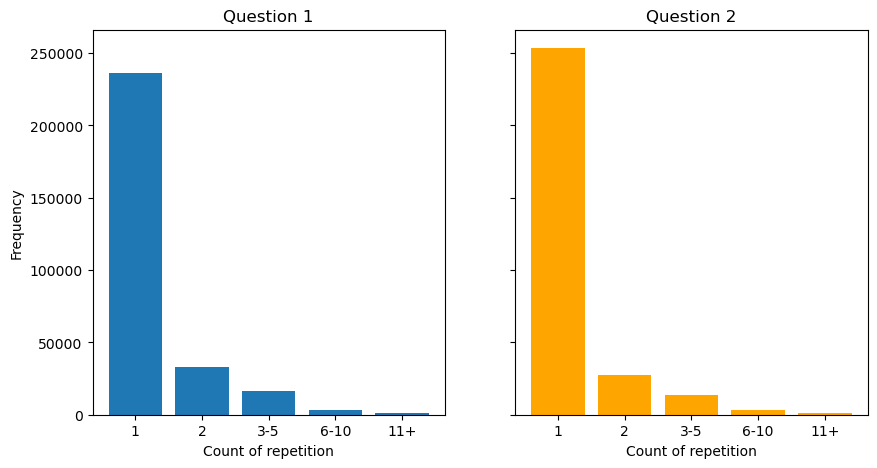

In [24]:
# create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# plot the first histogram
ax1.bar(bin_counts_1.index.astype(str), bin_counts_1.values)
ax1.set_xlabel('Count of repetition')
ax1.set_ylabel('Frequency')
ax1.set_title('Question 1')

# plot the second histogram
ax2.bar(bin_counts_2.index.astype(str), bin_counts_2.values, color='orange')
ax2.set_xlabel('Count of repetition')
ax2.set_title('Question 2')

# set the x-axis limits to be the same for both subplots
ax1.set_xlim(ax2.get_xlim())

# display the plot
plt.show()

#### Check language

In [25]:
# initialize counters
english_questions = []
non_english_questions = []

In [26]:
# initialize progress bar with total number of rows
# pbar = tqdm(total=df.shape[0], desc='Detecting Language')
"""
# loop over both columns simultaneously
for q1, q2 in zip(df['question1'], df['question2']):
    try:
        # try to detect the language of the text
        lang1 = detect(q1)
        lang2 = detect(q2)

        # if both texts are in English, increment the English counter
        if lang1 == 'en' and lang2 == 'en':
            english_questions.append (q1, q2)
        # otherwise, increment the non-English counter
        else:
            non_english_questions.append (q1, q2)
            
        # update progress bar
        #pbar.update()
        #pbar.set_postfix({'English ': english_count, 'Non-English ': non_english_count, 'of ': f"{df.shape[0]}"} )
        
    # pass over if it is unable to detect the language (otherwise it will fail)
    except:
        pass

# close progress bar
#pbar.close()

# print the counts
#print(f"English questions: {english_count} of {df.shape[0]}")
#print(f"Non-English questions: {non_english_count} of {df.shape[0]}")

"""

'\n# loop over both columns simultaneously\nfor q1, q2 in zip(df[\'question1\'], df[\'question2\']):\n    try:\n        # try to detect the language of the text\n        lang1 = detect(q1)\n        lang2 = detect(q2)\n\n        # if both texts are in English, increment the English counter\n        if lang1 == \'en\' and lang2 == \'en\':\n            english_questions.append (q1, q2)\n        # otherwise, increment the non-English counter\n        else:\n            non_english_questions.append (q1, q2)\n            \n        # update progress bar\n        #pbar.update()\n        #pbar.set_postfix({\'English \': english_count, \'Non-English \': non_english_count, \'of \': f"{df.shape[0]}"} )\n        \n    # pass over if it is unable to detect the language (otherwise it will fail)\n    except:\n        pass\n\n# close progress bar\n#pbar.close()\n\n# print the counts\n#print(f"English questions: {english_count} of {df.shape[0]}")\n#print(f"Non-English questions: {non_english_count} of {

In [27]:
"""# pickle the output for both columns
with open('language_detector_list.pkl', 'wb') as f:
    pickle.dump({
                'English_questions': (english_questions),
                'Non-English_questions': (non_english_questions)
                }, f)
                """

"# pickle the output for both columns\nwith open('language_detector_list.pkl', 'wb') as f:\n    pickle.dump({\n                'English_questions': (english_questions),\n                'Non-English_questions': (non_english_questions)\n                }, f)\n                "

### Check y values

In [28]:
from tabulate import tabulate

data = df["is_duplicate"].value_counts()
table = [["No", data[0]], ["Yes", data[1]]]
headers = ["Is Duplicate", "Count"]

print(tabulate(table, headers=headers, tablefmt="fancy_grid"))

In [29]:
# looks like an unbalanced dataet

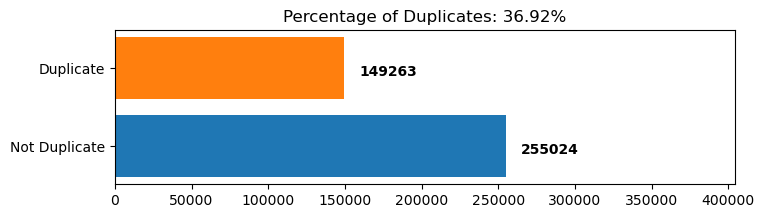

In [30]:
# define data
data = [255024, 149263]
labels = ['0', '1']

import matplotlib.pyplot as plt

# Count the values in the is_duplicate column
value_counts = df['is_duplicate'].value_counts()

# Calculate the percentage of duplicates
percentage_duplicates = value_counts[1] / (value_counts[0] + value_counts[1]) * 100

# Create the horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 2))
ax.barh(['Not Duplicate', 'Duplicate'], [value_counts[0], value_counts[1]], 
        color=['tab:blue', 'tab:orange'])
ax.set_xlim([0, len(df)])
ax.set_title('Percentage of Duplicates: {:.2f}%'.format(percentage_duplicates))

# Add labels to the bars
for i, v in enumerate(value_counts):
    ax.text(v + 10000, i - 0.1, str(v), color='black', fontweight='bold')

# Show the plot
plt.show()


In [31]:
# count the number of each label
value_counts = df['is_duplicate'].value_counts()

# calculate the percentage of each label
percentages = value_counts / len(df) * 100

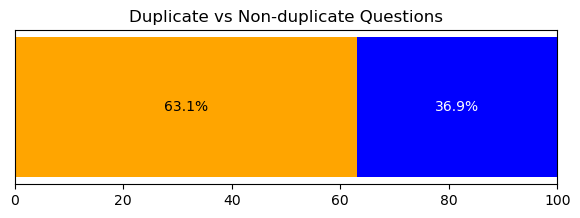

In [32]:
# plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(7, 2))

# plot the left half
ax.barh(0, percentages[0], color='orange', height=0.5, label='Not duplicates')

# plot the right half
ax.barh(0, percentages[1], left=percentages[0], color='blue', height=0.5, label='Duplicates')

# set x-axis limits
ax.set_xlim(0, 100)

# remove y-axis
ax.set_yticks([])

# display percentage labels
ax.text(percentages[0] / 2, 0.001, f"{percentages[0]:.1f}%", ha='center', va='center', color='black')
ax.text(percentages[0] + percentages[1] / 2, 0.001, f"{percentages[1]:.1f}%", ha='center', va='center', color='white')

# add title
ax.set_title("Duplicate vs Non-duplicate Questions")

# display plot
plt.show()



Train-Test split now (because I wanted to preserve the y values for EDA)

In [33]:
X = df.drop(["is_duplicate", "id", "qid1", "qid2"], axis=1)
y = df["is_duplicate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,question1,question2
174950,India: What are job options and future options...,Jobs and Careers in India: I am currently in m...
119443,Which is world's best romantic movie?,What is the best romantic movie of all time?
252943,Which is best place to live in hyderabad?,Which is best place to live Hyderabad or Mumbai?
13551,What should I do to be an athlete in a month?,What is shop act licence?
274898,How do you learn to code on WordPress?,In how much time can I learn to code a WordPre...


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

sentences = []
for text in X_train:
    sentences = sent_tokenize(text)
    for sentence in sentences:
        words = word_tokenize(sentences)
        sentences.append(words)

In [34]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [35]:
stop_words = stopwords.words('english')
porter = PorterStemmer()
q1_token_list = []

for text in X_train["question1"]:
    # to lower
    text = text.lower()

    # tokenize the sentence
    tokens = word_tokenize(text)

    # remove all tokens that are not alphabetic
    alpha_words = [word for word in tokens if word.isalpha()]

    # filter out stop words
    important_words = [word for word in alpha_words if not word in stop_words]

    # filter out small words
    big_words = [word for word in important_words if len(word) > 2]

    # stem words using PorterStemmer
    stemmed_words = [porter.stem(word) for word in big_words]

    # add the tokens to the list
    q1_token_list.append(stemmed_words)

In [36]:
q2_token_list = []

for text in X_train["question2"]:
    # to lower
    text = text.lower()

    # tokenize the sentence
    tokens = word_tokenize(text)

    # remove all tokens that are not alphabetic
    alpha_words = [word for word in tokens if word.isalpha()]

    # filter out stop words
    important_words = [word for word in alpha_words if not word in stop_words]

    # filter out small words
    big_words = [word for word in important_words if len(word) > 2]

    # stem words using PorterStemmer
    stemmed_words = [porter.stem(word) for word in big_words]

    # add the tokens to the list
    q2_token_list.append(stemmed_words)

In [37]:
print(q1_token_list[:5])
print(q2_token_list[:5])

[['india', 'job', 'option', 'futur', 'option', 'low', 'cgpa', 'graduat', 'percentag', 'engin', 'student', 'india'], ['world', 'best', 'romant', 'movi'], ['best', 'place', 'live', 'hyderabad'], ['athlet', 'month'], ['learn', 'code', 'wordpress']]
[['job', 'career', 'india', 'current', 'third', 'year', 'engin', 'cgpa', 'one', 'backlog', 'semest', 'decid', 'want', 'seek', 'job', 'firm', 'like', 'sigma', 'mba', 'option', 'better', 'compani', 'appli', 'order', 'get', 'decent', 'job'], ['best', 'romant', 'movi', 'time'], ['best', 'place', 'live', 'hyderabad', 'mumbai'], ['shop', 'act', 'licenc'], ['much', 'time', 'learn', 'code', 'wordpress', 'websit']]


In [38]:
# don't save it as a csv because the tokenization won't be preserved
# pickle the output for both columns
with open('tokens.pkl', 'wb') as f:
    pickle.dump({
                'question1': (q1_token_list),
                'question2': (q2_token_list)
                }, f)

In [39]:
# put into  df of tokens?

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

#### TF-IDF

In [40]:
# each row is a "document" - so q1 and q2 together
# since I dont want to exclude unique words that appear in a pair, but nowhere else, I'll leave min_df
    # the number of docs that the word has to appear in to count to the default of 1
# because my docs are small and have already been filtered, I'll also leave the max_features 
    # (the maximum number of words to be extracted) also at its default of none (ie no maximum)

# initialize the vectorizer with appropriate params
tdif_vectorizer = TfidfVectorizer ( # max_df is a value between 0 and 1
                                    # it says to ignore words that appear in more than 80% of documents
                                    max_df = 0.8,

                                    # ngram range captures words either side for context
                                    ngram_range = (1, 3) 
                                    )

In [41]:
# ughhhh tf-idf takes a list of strings, but we have a list of lists (tokens)

# have to re-join the tokens in each list to form a single string
q1_train_docs = [' '.join(tokens) for tokens in q1_token_list]
q2_train_docs = [' '.join(tokens) for tokens in q2_token_list]

# fit and transform q1_train_docs
q1_train_tfidf = tdif_vectorizer.fit_transform(q1_train_docs)

# fit and transform q2_train_docs
q2_train_tfidf = tdif_vectorizer.fit_transform(q2_train_docs)

### Word-2-Vec

In [42]:
# initialize word-2-vec model which will retain words that appear more than twice
# default = 5
# window controls how many words before and after the current word are used to predict its embedding vector
# default = 5

# create word2vec model for question1 column
q1_word2vec = Word2Vec(q1_token_list, min_count=2)

# create word2vec model for question2 column
q2_word2vec = Word2Vec(q2_token_list, min_count=2)

In [43]:
# display dictionary of all unique words that appear more than twice
vocabulary1 = q1_word2vec.wv.key_to_index
print(vocabulary1)
vocabulary2 = q2_word2vec.wv.key_to_index
print(vocabulary2)

{'best': 0, 'get': 1, 'india': 2, 'like': 3, 'differ': 4, 'use': 5, 'peopl': 6, 'good': 7, 'way': 8, 'would': 9, 'make': 10, 'one': 11, 'quora': 12, 'learn': 13, 'time': 14, 'life': 15, 'money': 16, 'know': 17, 'work': 18, 'mean': 19, 'year': 20, 'question': 21, 'thing': 22, 'indian': 23, 'much': 24, 'think': 25, 'start': 26, 'new': 27, 'someon': 28, 'engin': 29, 'book': 30, 'mani': 31, 'becom': 32, 'find': 33, 'happen': 34, 'trump': 35, 'day': 36, 'movi': 37, 'ever': 38, 'job': 39, 'without': 40, 'onlin': 41, 'world': 42, 'want': 43, 'feel': 44, 'take': 45, 'girl': 46, 'person': 47, 'better': 48, 'first': 49, 'note': 50, 'univers': 51, 'compani': 52, 'love': 53, 'english': 54, 'improv': 55, 'need': 56, 'account': 57, 'possibl': 58, 'program': 59, 'prepar': 60, 'could': 61, 'phone': 62, 'number': 63, 'buy': 64, 'compar': 65, 'live': 66, 'countri': 67, 'languag': 68, 'ask': 69, 'chang': 70, 'student': 71, 'realli': 72, 'weight': 73, 'stop': 74, 'studi': 75, 'app': 76, 'websit': 77, 'ans

In [44]:
q1_vectors = []
q2_vectors = []

for q1, q2 in zip(q1_token_list, q2_token_list):
    q1_vecs = []
    q2_vecs = []
    
    for word in q1:
        try:
            q1_vecs.append(q1_word2vec.wv[word])
        except KeyError:
            # word not in vocabulary
            continue
    
    for word in q2:
        try:
            q2_vecs.append(q2_word2vec.wv[word])
        except KeyError:
            # word not in vocabulary
            continue
    
    q1_vectors.append(q1_vecs)
    q2_vectors.append(q2_vecs)


In [45]:
print(q1_word2vec)
print(q2_word2vec)

Word2Vec(vocab=23092, vector_size=100, alpha=0.025)
Word2Vec(vocab=20920, vector_size=100, alpha=0.025)


### Word-2-Vec on whole questions rather than individual words

* Sentence vectors are created by averaging the embeddings of the individual words in a sentence. 
* The resulting sentence vector represents the overall meaning of the sentence.
* The np.mean function is used to compute the mean of the embeddings for each word in the sentence. 
* The if statement filters out words that are not in the Word2Vec vocabulary, as those words do not have embeddings. 
* The resulting sentence vectors can be used to represent the meaning of each question for further analysis or modeling.

In [78]:
# Initialize empty lists to hold the sentence vectors for q1 and q2
q1_sentence_vectors = []
q2_sentence_vectors = []

In [80]:
# Loop over each pair of token lists for q1 and q2, and compute the word vectors
for q1_tokens, q2_tokens in zip(q1_token_list, q2_token_list):

    # Initialize empty lists to hold the word vectors for q1 and q2
    q1_word_vectors = []
    q2_word_vectors = []
    
    # Compute the word vectors for q1
    for word in q1_tokens:
        try:
            q1_word_vectors.append(q1_word2vec.wv[word])
        except KeyError:
            # word not in vocabulary
            continue
    
    # Compute the word vectors for q2
    for word in q2_tokens:
        try:
            q2_word_vectors.append(q2_word2vec.wv[word])
        except KeyError:
            # word not in vocabulary
            continue
    
    # Compute the sentence vectors for q1 and q2 by taking the mean of the word vectors
    q1_sentence_vector = np.mean(q1_word_vectors, axis=0)
    q2_sentence_vector = np.mean(q2_word_vectors, axis=0)
    
    # Append the sentence vectors to the q1_vectors and q2_vectors lists
    q1_sentence_vectors.append(q1_sentence_vector)
    q2_sentence_vectors.append(q2_sentence_vector)

c:\Users\emily\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\emily\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [81]:
q1_sentence_vectors

[array([ 0.20823891, -0.1723548 , -0.47479045, -0.61200756,  0.8555184 ,
        -0.18130147, -0.27644467,  0.0685726 , -0.57254976,  0.14979097,
        -0.28395978, -0.796161  , -0.02267943,  1.4043541 ,  1.5123299 ,
        -0.6218607 ,  0.39511284, -1.1738613 ,  0.37804374, -1.297356  ,
         0.36374792,  0.6733887 ,  0.5653556 ,  0.00894972, -0.14826234,
        -0.05153547, -0.29698637,  0.03801418, -0.01579075, -0.4127154 ,
         0.46844995, -0.02106224, -0.01961241,  0.8670175 ,  0.6599886 ,
         0.08719313, -0.1570868 ,  0.21423693,  0.48998013, -0.22864534,
        -0.9053667 , -0.27865648,  0.5596273 ,  0.65941685,  0.15969406,
        -0.20518707, -0.1289287 ,  0.35747847, -1.5960449 , -0.53631663,
         0.9893923 ,  0.28535637,  0.5518295 ,  1.1940966 ,  0.20047517,
        -0.01302634,  0.43233347,  1.0914079 , -1.0503602 ,  0.19600557,
         0.20658147, -1.0545596 ,  0.41394916,  0.9192624 , -0.7824352 ,
         0.5195951 , -0.6120313 ,  0.57736135, -0.0

In [71]:
# Convert the q1_vectors and q2_vectors lists to numpy arrays
q1_vectors = np.array(q1_vectors, dtype=object)
q2_vectors = np.array(q2_vectors, dtype=object)

# Concatenate the sentence vectors for q1 and q2
X_train_sentence_vectors = np.concatenate((q1_vectors[:, None], q2_vectors[:, None]), axis=1)

# Print the shape of the concatenated sentence vectors
print("X_train_sentence_vectors shape:", X_train_sentence_vectors.shape)

X_train_sentence_vectors.dtype

X_train_sentence_vectors shape: (323429, 2)


dtype('O')

In [75]:
max_len = max(len(v) for v in q1_vectors + q2_vectors)

q1_vectors_padded = np.zeros((len(q1_vectors), max_len))
for i, vector in enumerate(q1_vectors):
    q1_vectors_padded[i, :len(vector)] = vector

q2_vectors_padded = np.zeros((len(q2_vectors), max_len))
for i, vector in enumerate(q2_vectors):
    q2_vectors_padded[i, :len(vector)] = vector

X_train_sentence_vectors = np.concatenate((q1_vectors_padded, q2_vectors_padded), axis=1)


TypeError: object of type 'numpy.float64' has no len()

### Word count
Apparently CountVectorizer() is better than bag-of-words for large datasets, so I'll use that

In [50]:
# choose some params.
# min_df default is 1. Like in tf-idf, I'll leave it at 1

# one is vocabulary. I can pass in my word-2-vec vocab if i transform it
# extract the list of words from the dictionary
q1_word_list = list(q1_word2vec.wv.key_to_index.keys())

q1_count_vectorizer = CountVectorizer(vocabulary = q1_word_list,  #taking vocab from word-2-vec
                                      decode_error='ignore',      # default 'strict' will raise an exception if there is a decoding error. This will skip over it.
                                      ngram_range = (1, 3),
                                      max_df = 0.8)

In [51]:
# fit and transform the tokenized documents
q1_count_vectors = q1_count_vectorizer.fit_transform(q1_train_docs)

In [52]:
q2_word_list = list(q2_word2vec.wv.key_to_index.keys())

q2_count_vectorizer = CountVectorizer(vocabulary = q2_word_list,  #taking vocab from word-2-vec
                                      decode_error='ignore',      # default 'strict' will raise an exception if there is a decoding error. This will skip over it.
                                      ngram_range = (1, 3),
                                      max_df = 0.8)

In [53]:
# fit and transform the tokenized documents
q2_count_vectors = q2_count_vectorizer.fit_transform(q2_train_docs)

In [54]:
print(q1_count_vectorizer.get_feature_names())

['best', 'get', 'india', 'like', 'differ', 'use', 'peopl', 'good', 'way', 'would', 'make', 'one', 'quora', 'learn', 'time', 'life', 'money', 'know', 'work', 'mean', 'year', 'question', 'thing', 'indian', 'much', 'think', 'start', 'new', 'someon', 'engin', 'book', 'mani', 'becom', 'find', 'happen', 'trump', 'day', 'movi', 'ever', 'job', 'without', 'onlin', 'world', 'want', 'feel', 'take', 'girl', 'person', 'better', 'first', 'note', 'univers', 'compani', 'love', 'english', 'improv', 'need', 'account', 'possibl', 'program', 'prepar', 'could', 'phone', 'number', 'buy', 'compar', 'live', 'countri', 'languag', 'ask', 'chang', 'student', 'realli', 'weight', 'stop', 'studi', 'app', 'websit', 'answer', 'googl', 'lose', 'busi', 'import', 'donald', 'long', 'effect', 'develop', 'look', 'war', 'sex', 'colleg', 'friend', 'facebook', 'presid', 'place', 'black', 'say', 'exampl', 'game', 'help', 'see', 'old', 'write', 'system', 'come', 'state', 'comput', 'win', 'market', 'free', 'name', 'read', 'major

c:\Users\emily\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [55]:
# get the first 3 rows of the matrix
sparse_q1_count_vectors = q1_count_vectors[:3]

# convert to dense matrix
dense_q1_count_vectors = sparse_q1_count_vectors.toarray()

# create a DataFrame with the results
q1_count_df = pd.DataFrame(dense_q1_count_vectors, columns=q1_count_vectorizer.get_feature_names())

q1_count_df.head()

,best,get,india,like,differ,use,peopl,good,way,would,...,marsh,vishakapatnam,mg,kay,maharashtrian,cigaret,dickinson,curaçao,rotc,nacro
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Count

In [56]:
def count_overlap_words(q1_token_list, q2_token_list):
    q1_set = set(q1_token_list)
    q2_set = set(q2_token_list)
    overlap_set = q1_set.intersection(q2_set)
    return len(overlap_set)

In [57]:
overlap_counts = []
for i in range(len(q1_token_list)):
    overlap_count = count_overlap_words(q1_token_list[i], q2_token_list[i])
    overlap_counts.append(overlap_count)
    
# Add the overlap count column to your original dataframe
X_train['overlap_count'] = overlap_counts

X_train.head()

,question1,question2,overlap_count
174950,India: What are job options and future options...,Jobs and Careers in India: I am currently in m...,5
119443,Which is world's best romantic movie?,What is the best romantic movie of all time?,3
252943,Which is best place to live in hyderabad?,Which is best place to live Hyderabad or Mumbai?,4
13551,What should I do to be an athlete in a month?,What is shop act licence?,0
274898,How do you learn to code on WordPress?,In how much time can I learn to code a WordPre...,3


### Sentence transformer using neural network

Sentence transformers use deep learning models, such as transformers or LSTMs, 
to encode the meaning of the entire sentence into a dense vector representation, 
which can be used for various natural language processing tasks including semantic similarity
The model.encode() method returns a list of 768-dimensional vectors, where each vector represents the embedding of a single sentence.

In [84]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained BERT model
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Generate sentence embeddings for q1 and q2
q1_bert_embeddings = model.encode(q1_train_docs)
q2_bert_embeddings = model.encode(q2_train_docs)

### cosine similarity

In [62]:
print(q1_sentence_vectors[0:2])

[0.02009917 0.22923619]


In [63]:
print("q1_sentence_vectors shape:", q1_sentence_vectors.shape)
print("q2_sentence_vectors shape:", q2_sentence_vectors.shape)

q1_sentence_vectors shape: (100,)
q2_sentence_vectors shape: (100,)


In [61]:
# Concatenate the sentence vectors for q1 and q2
X_train_sentence_vectors = np.concatenate((q1_sentence_vectors, q2_sentence_vectors))

In [ ]:
# Compute the cosine similarity between the sentence vectors for q1 and q2
cos_sim = cosine_similarity(X_train_sentence_vectors[:, :300], X_train_sentence_vectors[:, 300:])

# This outputs a matrix of cosine similarity scores between each pair of questions in your training set.

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

Variables Menu:
* q1_token_list (word tokenized and clened)
* q1_train_docs = but clean stemmed Strings
* q1_word_list = list(q1_word2vec.wv.key_to_index.keys()) - all the words in the Q1 vocab
* q1_train_tfidf: sparse matrix ocontaining the TF-IDF values (representing TF-IDF weights) for each term in each row   #NUMERIC
* q1_sentence_vectors: created by taking the mean of each word vector in the sentence (good for comparing similarity)   #NUMERIC
* q1_count_vectors: simpler version of TF-IDF that doesn't take into account the IDF part (again, a sparse matrix)      #NUMERIC
* q1 and q2 overlap count (right now this is only in X_test, which is unclean. Might need to move it somewhere else)    #NUMERIC

In [82]:
# concatenate sparse matrices (TF-IDF word vecotrs, TF-IDF sentence vectors, CountVectorizer)
# these can be concatenated horizontally or vertically
# horizontally will make all the words triplicated and will lead to greater processing time, so I'll do it vertically
# but if i vertically stack, won't the overlap_counts not work and the row-ing not be preserved

from scipy.sparse import vstack
from scipy.sparse import hstack

# create vertically stacked matrices for q1 and q2
#X_train_sparse_q1 = vstack((q1_train_tfidf, q1_count_vectors, q1_sentence_vectors))
#X_train_sparse_q2 = vstack((q2_train_tfidf, q2_count_vectors, q2_sentence_vectors)

In [83]:
# change overlap_counts into an array so we can input it properly
overlap_counts_array = np.array(overlap_counts).reshape(-1, 1)

# stack everything horizontally. Why not.

# List of stackable components
stackable_matrices = [q1_train_tfidf, q1_count_vectors, q1_sentence_vectors, overlap_counts_array]

# Horizontally stack the matrices
X_train_sparse = hstack(stackable_matrices)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (323429,) + inhomogeneous part.

In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# assume X_train is your DataFrame with columns 'question1' and 'question2'

# train word2vec model
all_tokens = X_train['question1'].tolist() + X_train['question2'].tolist()
word2vec_model = Word2Vec(all_tokens, min_count=2)

# generate sentence embeddings for each 'q1' and 'q2' pair
X_train['q1_embedding'] = X_train['question1'].apply(lambda x: word2vec_model.wv[x].mean(axis=0))
X_train['q2_embedding'] = X_train['question2'].apply(lambda x: word2vec_model.wv[x].mean(axis=0))

# compute cosine similarity between sentence embeddings
X_train['cosine_similarity'] = X_train.apply(lambda x: cosine_similarity(x['q1_embedding'].reshape(1, -1), x['q2_embedding'].reshape(1, -1))[0][0], axis=1)

# classify 'q1' and 'q2' pairs as either similar or dissimilar
similarity_threshold = 0.8
X_train['is_similar'] = X_train['cosine_similarity'].apply(lambda x: True if x >= similarity_threshold else False)


KeyError: "Key 'India: What are job options and future options for low CGPA or graduation percentage engineering students in India (5-6)?' not present"

Testing

In [ ]:
'''
When you want to use the TfidfVectorizer on your test set, you should only call the transform method on it, 
using the same TfidfVectorizer instance that you fitted on the training set. Here's an example:
q1_test_tfidf = tdif_vectorizer.transform(q1_test_token_list)
q2_test_tfidf = tdif_vectorizer.transform(q2_test_token_list)
'''

Outtakes to get working in the future

In [ ]:
# tokenize X_train into sentences and then words
# doing it this way preserves the upper-level tokenization of sentences 
# AND the lower lever tokenizaion into words

# apparently it's better to remove punctuation BEFORE tokenizing into words (but clearly AFTER tokenizing into sentences)
# apparently you don't need to tokenize the y_train

# initialize progress bar with total number of rows
#pbar = tqdm(total = X_train.shape[0], desc = 'Tokenizing', position = 0, leave = True)

"""q1_sentences = []
q1_word_tokens = []

# tokenize question1
for text in X_train["question1"]:

    # tokenize the sentence
    q1_sentence_tokens = sent_tokenize(text)

    # "extend" adds multiple elements, in batches, to the end of a list, whereas "append" adds one element
    q1_sentences.extend(q1_sentence_tokens)

    # tokenize the words and clean them
    for sent in q1_sentence_tokens:
        q1_word_tokens = word_tokenize(sent)
        q1_clean_tokens = [token.lower() for token in q1_word_tokens if token not in string.punctuation]
        q1_word_tokens.extend(q1_clean_tokens)

        # update progress bar
        pbar.update(1)
        pbar.set_postfix({'rows tokenized: ': pbar.n, '  of:  ': df.shape[0]})

# close progress bar
pbar.close()
"""